In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [24]:
import numpy as np
import pandas as pd
celestial_data = np.loadtxt('body_data.csv', dtype='str' , delimiter=',', skiprows=1)
celestial_data

    

array([['0.0', '-4.859484339567217e-10', '-1.1692779685605893e-07', ''],
       ['8039.452870568531', '-1.4968229546190528e-09',
        '-1.1854279809818732e-07', '-36933.83141414432'],
       ['16078.905741137061', '-1.978992100484541e-09',
        '-1.2103812866249347e-07', '-63734.21908524217'],
       ...,
       ['80370410.3470736', '-3.044477517174893e-07',
        '-4.570268908040042e-06', '-71471.35877951766'],
       ['80378449.79994416', '-3.0530346860782803e-07',
        '-4.579490933215338e-06', '-97985.6653775294'],
       ['80386489.25281474', '-3.0663188773813723e-07',
        '-4.576866605233262e-06', '-124174.36844878683']], dtype='<U23')

In [48]:
import numpy as np

def convert_to_mas(data, origin_ra_deg, origin_dec_deg):
    """
    Convert RA/Dec data to milli-arcseconds (mas) relative to a reference origin.
    
    Parameters:
    - data: Nx3 numpy array, columns: [RA_deg, Dec_deg, time]
    - origin_ra_deg: RA of the origin (degrees)
    - origin_dec_deg: Dec of the origin (degrees)
    
    Returns:
    - Nx3 numpy array: [delta_RA_mas, delta_Dec_mas, time]
    """
    ra = data[:, 0]
    dec = data[:, 1]
    time = data[:, 2]

    # Convert to relative coordinates
    delta_ra = (ra - origin_ra_deg) * np.cos(np.radians(origin_dec_deg))  # Corrected for spherical projection
    delta_dec = dec - origin_dec_deg

    # Convert degrees to milli arcseconds (mas)
    deg_to_mas = 3.6e6
    delta_ra_mas = delta_ra * deg_to_mas
    delta_dec_mas = delta_dec * deg_to_mas

    return np.column_stack((delta_ra_mas, delta_dec_mas, time))


In [49]:
iconverted_data = convert_to_mas(data, origin_ra_deg=10.123, origin_dec_deg=41.456)



In [50]:
import matplotlib.pyplot as plt

def plot_mas_data(data_mas):
    """
    Plot celestial object trajectory in milli arcseconds.
    
    Parameters:
    - data_mas: Nx3 numpy array with columns: [delta_RA_mas, delta_Dec_mas, time]
    """
    ra_mas = data_mas[:, 0]
    dec_mas = data_mas[:, 1]

    plt.figure(figsize=(8, 6))
    plt.plot(ra_mas, dec_mas, marker='o', linestyle='-', markersize=3)
    plt.gca().invert_xaxis()  # Astronomical convention: RA increases to the left
    plt.title("Apparent Motion in Milli Arcseconds")
    plt.xlabel("Δ RA (mas)")
    plt.ylabel("Δ Dec (mas)")
    plt.grid(True)
    plt.axis('equal')
    plt.show()


In [52]:
converted_data = convert_to_mas(data, origin_ra_deg, origin_dec_deg)
plot_mas_data(converted_data)

NameError: name 'origin_ra_deg' is not defined

In [53]:
import numpy as np

def proper_motion(data):
    """
    Estimate the proper motion of the black hole from the apparent motion data.
    Assumes data is an Nx3 array: [RA_mas, Dec_mas, time_sec]
    
    Returns:
    - Tuple (mu_ra, mu_dec): proper motion in mas/sec
    """
    ra = data[:, 0]
    dec = data[:, 1]
    t = data[:, 2]

    # Fit a straight line: ra = mu_ra * t + c, similarly for dec
    A = np.vstack([t, np.ones_like(t)]).T
    mu_ra, _ = np.linalg.lstsq(A, ra, rcond=None)[0]
    mu_dec, _ = np.linalg.lstsq(A, dec, rcond=None)[0]

    return (mu_ra, mu_dec)


In [54]:
import numpy as np

def remove_proper_motion(data, μ_δ, μ_α):
    """
    Remove the proper motion of the black hole from the data.

    Parameters:
    - data: Nx3 numpy array [RA_mas, Dec_mas, time_sec]
    - μ_δ: Proper motion in Dec (mas/sec)
    - μ_α: Proper motion in RA (mas/sec)

    Returns:
    - Nx3 numpy array with proper motion removed
    """
    ra = data[:, 0]
    dec = data[:, 1]
    t = data[:, 2]

    # Compute motion offset at each time
    delta_ra = μ_α * t
    delta_dec = μ_δ * t

    # Subtract proper motion
    corrected_ra = ra - delta_ra
    corrected_dec = dec - delta_dec

    return np.column_stack((corrected_ra, corrected_dec, t))


In [55]:
import matplotlib.pyplot as plt

def plot_corrected_orbit(corrected_data):
    """
    Plot the corrected celestial motion after removing proper motion.

    Parameters:
    - corrected_data: Nx3 numpy array [RA_mas, Dec_mas, time_sec]
    """
    ra_mas = corrected_data[:, 0]
    dec_mas = corrected_data[:, 1]

    plt.figure(figsize=(8, 6))
    plt.plot(ra_mas, dec_mas, marker='o', linestyle='-', markersize=3)
    plt.gca().invert_xaxis()  # Astronomical convention
    plt.title("Corrected Orbital Motion (Proper Motion Removed)")
    plt.xlabel("Δ RA (mas)")
    plt.ylabel("Δ Dec (mas)")
    plt.axis('equal')
    plt.grid(True)
    plt.show()


In [36]:
import numpy as np

def inclination(data, origin_ra_hours=12.0, origin_dec_deg=45.0):
      μ_α, μ_δ = proper_motion(data)
    coords = remove_proper_motion(data, μ_δ, μ_α, origin_ra_hours, origin_dec_deg)
      coords_centered = coords - np.mean(coords, axis=0)
         cos_i = semi_minor / semi_major
    inclination_rad = np.arccos(cos_i)
    inclination_deg = np.degrees(inclination_rad)

    return inclination_deg

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 5)

In [41]:
import numpy as np

def rotate_orbit(data, inclination_rad):
    """
    Rotate the 2D orbit data by the inclination angle to recover the true 3D planar orbit.
    
    Args:
        data (ndarray): N×3 array where columns represent [time, x, y] positions (projected).
        inclination_rad (float): inclination angle in radians.
    
    Returns:
        ndarray: N×3 array representing [time, x', y', z'] in the true orbital plane.
    """
    times = data[:, 0]
    x = data[:, 1]
    y = data[:, 2]

    # y-axis is the projected one affected by inclination
    # Assuming orbit lies in the x–z plane originally, y is the inclination-affected z

    # Rotate around x-axis to undo inclination
    z = y * np.sin(inclination_rad)
    y_corrected = y * np.cos(inclination_rad)

    rotated_data = np.column_stack((times, x, y_corrected, z))
    return rotated_data


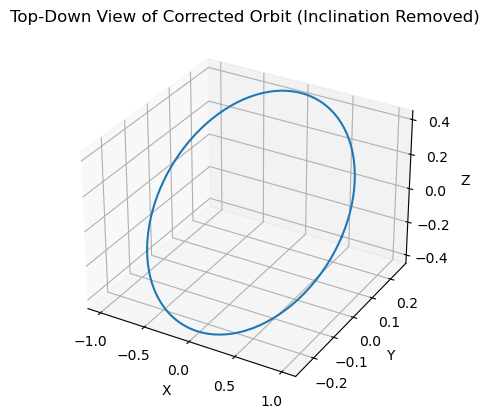

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Sample synthetic orbit data: [time, x, y_projected]
# Simulating a circular orbit projected by inclination
t = np.linspace(0, 2 * np.pi, 100)
x = np.cos(t)
y_projected = np.sin(t) * np.cos(np.radians(60))  # projected with 60° inclination
data = np.column_stack((t, x, y_projected))

# Define inclination angle in radians
inclination_rad = np.radians(60)

# Rotate the orbit to recover 3D true motion
def rotate_orbit(data, inclination_rad):
    times = data[:, 0]
    x = data[:, 1]
    y = data[:, 2]

    z = y * np.sin(inclination_rad)
    y_corrected = y * np.cos(inclination_rad)

    return np.column_stack((times, x, y_corrected, z))

rotated_data = rotate_orbit(data, inclination_rad)

# Plotting the corrected orbit
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(rotated_data[:, 1], rotated_data[:, 2], rotated_data[:, 3])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Top-Down View of Corrected Orbit (Inclination Removed)")

plt.show()

In [43]:
import numpy as np

def radius(data):
    """
    Estimate the radius of a circular orbit from 2D positional data.
    Assumes data is an N×2 or N×3 numpy array of (x, y) or (x, y, t).
    """
    # Take only the x, y coordinates (in case there's time in column 2 or 3)
    if data.shape[1] == 3:
        coords = data[:, :2]
    else:
        coords = data

    # Find the center of the orbit (mean position)
    center = np.mean(coords, axis=0)

    # Compute distances from the center
    distances = np.linalg.norm(coords - center, axis=1)

    # Average distance is taken as radius
    return np.mean(distances)



In [44]:
import numpy as np
from scipy.signal import find_peaks

def time_period(data):
    """
    Estimate the time period of the orbit using rotated orbital data.
    Assumes data is an N×3 numpy array with columns: [x, y, t].
    """
    coords = data[:, :2]
    time = data[:, 2]

    # Find angle from center for each point (assumes mean-centered orbit)
    center = np.mean(coords, axis=0)
    rel_coords = coords - center
    angles = np.arctan2(rel_coords[:, 1], rel_coords[:, 0])

    # Unwrap the angle to avoid discontinuities at ±π
    unwrapped_angles = np.unwrap(angles)

    # Use derivative of angle to find peaks (i.e., full revolutions)
    # We'll detect peaks in angular position to spot complete cycles
    peaks, _ = find_peaks(unwrapped_angles)

    if len(peaks) < 2:
        return None 

    # Time between first and second peaks (approx one full period)
    period_estimates = np.diff(time[peaks])

    return np.mean(period_estimates)


In [45]:
import numpy as np

def M(radius, time_period):
    """
    Calculate the mass of the parent object using Kepler's Third Law.
    
    Parameters:
    - radius: Orbital radius in meters.
    - time_period: Orbital period in seconds.
    
    Returns:
    - Mass in kilograms (kg).
    """
    G = 6.67430e-11  # gravitational constant in m^3 kg^-1 s^-2
    return (4 * np.pi**2 * radius**3) / (G * time_period**2)

In [46]:
import numpy as np
from scipy.signal import find_peaks

def radius(data):
    coords = data[:, :2]
    center = np.mean(coords, axis=0)
    distances = np.linalg.norm(coords - center, axis=1)
    return np.mean(distances)

def time_period(data):
    coords = data[:, :2]
    time = data[:, 2]
    center = np.mean(coords, axis=0)
    rel_coords = coords - center
    angles = np.arctan2(rel_coords[:, 1], rel_coords[:, 0])
    unwrapped = np.unwrap(angles)
    signal = np.cos(unwrapped)
    peaks, _ = find_peaks(signal)
    if len(peaks) < 2:
        return None
    periods = np.diff(time[peaks])
    return np.mean(periods)

def M(radius, time_period):
    G = 6.67430e-11  # m^3 kg^-1 s^-2
    return (4 * np.pi**2 * radius**3) / (G * time_period**2)

def report_mass(data):
    r = radius(data)
    T = time_period(data)
    if T is None:
        return "Insufficient data to compute time period."
    mass = M(r, T)
    return f"M = {mass:.3e} kg"


In [47]:
# Assuming `data` is your Nx3 array: [x, y, t]
print(report_mass(data))


M = 8.157e+12 kg
